<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/attention_init_alex/notebooks/TransGAN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
# Check GPU
!nvidia-smi

Sun Apr 18 14:52:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    39W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# from torchsummary import summary
from types import SimpleNamespace

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# gdrive = Path('drive/MyDrive')
gdrive = Path('/home/AP')

# Create a required checkpoint instance. 
# If does not exists, Checkpoint class will create one.
ckp_folder = gdrive/'attn_init'

In [4]:
!git clone --single-branch --branch attention_init_alex https://github.com/azfarkhoja305/GANs.git
!git -C GANs/ pull

fatal: destination path 'GANs' already exists and is not an empty directory.
Already up to date.


In [5]:
Path.ls = lambda x: list(x.iterdir())
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [6]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from utils.utils import check_gpu, display_images, set_seed
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

In [7]:
# seed notebook
set_seed(seed=123)
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [8]:
!PYTHONPATH=./GANs python ./GANs/scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified
fid_stats/cifar_10_valid_fid_stats.npz exists. Exiting !!!


# Training

In [9]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999
num_epochs = 200
augments = "translation,cutout,color"

Files already downloaded and verified


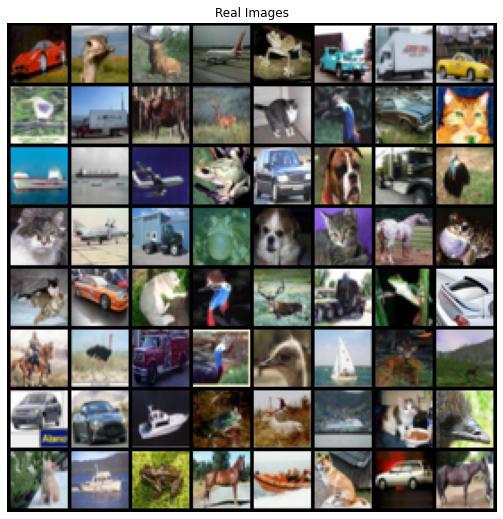

In [10]:
# Add Horizontal Flip by default
tfms = [transforms.RandomHorizontalFlip()]
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, tfms=tfms, 
                        num_workers=2, drop_last=True)
display_images(dataset.train_loader)

In [11]:
Gen = TGenerator(latent_dims=latent_dims, use_att_mask=True).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

## Generator Co-task

In [12]:
# from models.layers import LinearReshape
# bottom_width, embed_chs =  Gen.bottom_width, Gen.embed_chs
# ct_in_layer = LinearReshape(in_dims=3, out_dims=embed_chs//4,
#                             width=bottom_width*2, embed_chs=embed_chs//4)
# TGenerator.ct_in_layer = ct_in_layer.to(device)
# # python magic :)
# hasattr(Gen, "ct_in_layer")

In [13]:
# def super_resolution(self, x):
#     """ Start from the 2nd stage of the Generator for now. """
#     # Push channels to last dimention and project
#     x = self.ct_in_layer(x.permute(0,2,3,1)) 
#     for i, blocks in enumerate(self.upsample_block):
#         if i == 0:   # skip upsample
#              x = x + self.pos_embed[i+1]
#         else:    x = self.pixel_upsample[i](x) + self.pos_embed[i+1]
#         for blk in blocks:
#             x  = blk(x)
#     x = self.to_rgb(x)
#     return x.contiguous()

In [14]:
# TGenerator.super_resolution = super_resolution
# hasattr(Gen, "super_resolution")

In [15]:
def reduce_resolution(image_batch):
    """ Function to reduce the resolution of an image by half. """
    return F.interpolate(image_batch, scale_factor=0.5, mode='bilinear',
                          align_corners=False, recompute_scale_factor=False)

In [16]:
# @torch.no_grad()
# def pass_one_batch():
#     targ_img = next(iter(dataset.valid_loader))[0]
#     lowres_img = reduce_resolution(targ_img.to(device))
#     gen_img = TGen.super_resolution(lowres_img)

#     improved_img_grid = vutils.make_grid(gen_img.cpu(), padding=2, normalize=True)
#     target_img_grid = vutils.make_grid(targ_img.cpu(), padding=2, normalize=True)
#     lowres_img_grid = vutils.make_grid(lowres_img.cpu(), padding=2, normalize=True)
#     return lowres_img_grid, improved_img_grid, target_img_grid

In [17]:
mse_loss = nn.MSELoss(reduction='mean')
lamb = 50.0

## Continue Training Loop

In [18]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args,augments=augments).to(device)
# summary(Dis,(3,32,32,))

In [19]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [20]:
loss_logs = {'gen_loss': [], 'dis_loss': []}
img_list = []

In [21]:
ckp_class = Checkpoint(ckp_folder, max_epochs=num_epochs, num_ckps=40, start_after=0.025)

# check if any existing checkpoint exists, none found hence start_epoch is 0.
# Optimizer states also get saved
Gen, Dis, optG, optD, start_epoch, old_logs = \
                        ckp_class.check_if_exists(Gen, Dis, optG, optD)

loss_logs = old_logs or loss_logs
start_epoch #, loss_logs

0

In [22]:
# number of prints per epoch 
num = 4
print_at = np.linspace(100, len(dataset.train_loader)-1, num=num, dtype=np.int).tolist()

In [ ]:
for epoch in tqdm(range(start_epoch, num_epochs)):
    for i, data in enumerate(tqdm(dataset.train_loader, leave=False)):
        
        ###########################
        # (1) Update Dis network
        ###########################
        
        ## Train with all-real batch
        Dis.zero_grad()
        real = data[0].to(device)
        output_real = Dis(real).view(-1)

        ## Train with all-fake batch
        dis_z = torch.randn(dis_batch_sz, latent_dims, device=device)
        fake_1 = Gen(dis_z, epoch).detach()
        output_fake_1 = Dis(fake_1).view(-1)

        ## Compute loss and backpropagate
        errD = wgangp_eps_loss(Dis, real, fake_1, 1.0, output_real, output_fake_1)
        errD.backward()
        torch.nn.utils.clip_grad_norm_(Dis.parameters(), 5.0)
        optD.step()

        ###########################
        # (2) Update Gen network
        ###########################
        
        Gen.zero_grad()
        gen_z = torch.randn(gen_batch_sz, latent_dims, device=device)
        fake_2 = Gen(gen_z, epoch)
        output_fake_2 = Dis(fake_2).view(-1)
        errG = -torch.mean(output_fake_2)

        # Co-training task
        low_res_img = reduce_resolution(real)
        generated_img = Gen.super_resolution(low_res_img,epoch=epoch)
        co_train_loss = mse_loss(generated_img, real)

        errG += lamb * co_train_loss
        errG.backward()
        torch.nn.utils.clip_grad_norm_(Gen.parameters(), 5.0)
        optG.step()

        ###########################
        # (3) Output
        ###########################

        # Save Losses for plotting later
        loss_logs['gen_loss'].append(errG.item())
        loss_logs['dis_loss'].append(errD.item())

        if i in print_at:
            # Output training stats averged over last 100 iterations
            gen_mean = np.mean(loss_logs['gen_loss'][-100:])
            dis_mean = np.mean(loss_logs['dis_loss'][-100:])
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataset.train_loader)}]\t'
                  f'Loss_D: {round(gen_mean, 4)}\t',
                  f'Loss_G: {round(dis_mean, 4)}')
        
            # Check how the generator is doing by saving G's output on fixed_noise
            with torch.no_grad():
                fixed_fake = Gen(fixed_z, epoch).detach().cpu()
            img_list.append(vutils.make_grid(fixed_fake, padding=2, normalize=True))
    
    # Checkpoint
    ckp_class.at_epoch_end(Gen, Dis, optG, optD, epoch=epoch, loss_logs=loss_logs)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

[0/200][100/1562]	Loss_D: 3.0402	 Loss_G: 0.99
[0/200][587/1562]	Loss_D: 1.6779	 Loss_G: 0.1814
[0/200][1074/1562]	Loss_D: 1.615	 Loss_G: 0.1153
[0/200][1561/1562]	Loss_D: 1.6021	 Loss_G: 0.1289


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290><function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
        self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process  File "/opt/cond

[1/200][100/1562]	Loss_D: 1.3668	 Loss_G: 0.1163
[1/200][587/1562]	Loss_D: 1.2596	 Loss_G: 0.1929
[1/200][1074/1562]	Loss_D: 1.2181	 Loss_G: 0.2398
[1/200][1561/1562]	Loss_D: 1.2069	 Loss_G: 0.1536


  0%|          | 0/1562 [00:00<?, ?it/s]

[2/200][100/1562]	Loss_D: 1.0873	 Loss_G: 0.1851
[2/200][587/1562]	Loss_D: 1.1195	 Loss_G: 0.2183
[2/200][1074/1562]	Loss_D: 1.0508	 Loss_G: 0.1978
[2/200][1561/1562]	Loss_D: 0.99	 Loss_G: 0.2245


  0%|          | 0/1562 [00:00<?, ?it/s]

[3/200][100/1562]	Loss_D: 1.0793	 Loss_G: 0.2146
[3/200][587/1562]	Loss_D: 1.1577	 Loss_G: 0.2026
[3/200][1074/1562]	Loss_D: 1.197	 Loss_G: 0.1979
[3/200][1561/1562]	Loss_D: 1.2485	 Loss_G: 0.1664


  0%|          | 0/1562 [00:00<?, ?it/s]

[4/200][100/1562]	Loss_D: 1.0494	 Loss_G: 0.2547
[4/200][587/1562]	Loss_D: 1.0212	 Loss_G: 0.1956
[4/200][1074/1562]	Loss_D: 1.1202	 Loss_G: 0.1831
[4/200][1561/1562]	Loss_D: 1.1315	 Loss_G: 0.2334


  0%|          | 0/1562 [00:00<?, ?it/s]

[5/200][100/1562]	Loss_D: 1.1408	 Loss_G: 0.2313
[5/200][587/1562]	Loss_D: 1.0611	 Loss_G: 0.2224
[5/200][1074/1562]	Loss_D: 1.1724	 Loss_G: 0.2257
[5/200][1561/1562]	Loss_D: 1.1406	 Loss_G: 0.1851
=> Saving Checkpoint with name `GanModel_005.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[6/200][100/1562]	Loss_D: 1.1118	 Loss_G: 0.1844
[6/200][587/1562]	Loss_D: 1.1072	 Loss_G: 0.219
[6/200][1074/1562]	Loss_D: 1.106	 Loss_G: 0.2254
[6/200][1561/1562]	Loss_D: 0.9271	 Loss_G: 0.2226


  0%|          | 0/1562 [00:00<?, ?it/s]

[7/200][100/1562]	Loss_D: 1.0532	 Loss_G: 0.159
[7/200][587/1562]	Loss_D: 1.0157	 Loss_G: 0.2081
[7/200][1074/1562]	Loss_D: 1.0797	 Loss_G: 0.1677
[7/200][1561/1562]	Loss_D: 1.0458	 Loss_G: 0.162


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>    self._shutdown_workers()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", 

[8/200][100/1562]	Loss_D: 1.1062	 Loss_G: 0.1809
[8/200][587/1562]	Loss_D: 0.8808	 Loss_G: 0.1916
[8/200][1074/1562]	Loss_D: 0.8975	 Loss_G: 0.149
[8/200][1561/1562]	Loss_D: 0.8328	 Loss_G: 0.1739


  0%|          | 0/1562 [00:00<?, ?it/s]

[9/200][100/1562]	Loss_D: 0.977	 Loss_G: 0.1612
[9/200][587/1562]	Loss_D: 1.0652	 Loss_G: 0.1574
[9/200][1074/1562]	Loss_D: 1.0846	 Loss_G: 0.1595
[9/200][1561/1562]	Loss_D: 0.9242	 Loss_G: 0.1834


  0%|          | 0/1562 [00:00<?, ?it/s]

[10/200][100/1562]	Loss_D: 0.9026	 Loss_G: 0.1616
[10/200][587/1562]	Loss_D: 1.1171	 Loss_G: 0.1526
[10/200][1074/1562]	Loss_D: 0.9632	 Loss_G: 0.1426
[10/200][1561/1562]	Loss_D: 0.9843	 Loss_G: 0.1656
=> Saving Checkpoint with name `GanModel_010.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[11/200][100/1562]	Loss_D: 0.9112	 Loss_G: 0.134
[11/200][587/1562]	Loss_D: 1.0773	 Loss_G: 0.1628
[11/200][1074/1562]	Loss_D: 0.8933	 Loss_G: 0.1348
[11/200][1561/1562]	Loss_D: 1.0879	 Loss_G: 0.1494


  0%|          | 0/1562 [00:00<?, ?it/s]

[12/200][100/1562]	Loss_D: 1.0023	 Loss_G: 0.1771
[12/200][587/1562]	Loss_D: 0.9827	 Loss_G: 0.1234
[12/200][1074/1562]	Loss_D: 1.2065	 Loss_G: 0.1225
[12/200][1561/1562]	Loss_D: 0.9954	 Loss_G: 0.1243


  0%|          | 0/1562 [00:00<?, ?it/s]

[13/200][100/1562]	Loss_D: 0.9278	 Loss_G: 0.1359
[13/200][587/1562]	Loss_D: 0.8894	 Loss_G: 0.1582
[13/200][1074/1562]	Loss_D: 0.8863	 Loss_G: 0.1561
[13/200][1561/1562]	Loss_D: 0.8698	 Loss_G: 0.1563


  0%|          | 0/1562 [00:00<?, ?it/s]

[14/200][100/1562]	Loss_D: 0.9126	 Loss_G: 0.1517
[14/200][587/1562]	Loss_D: 0.9514	 Loss_G: 0.1338
[14/200][1074/1562]	Loss_D: 0.8115	 Loss_G: 0.1262
[14/200][1561/1562]	Loss_D: 0.8464	 Loss_G: 0.1166


  0%|          | 0/1562 [00:00<?, ?it/s]

[15/200][100/1562]	Loss_D: 0.9202	 Loss_G: 0.1858
[15/200][587/1562]	Loss_D: 0.9525	 Loss_G: 0.1555
[15/200][1074/1562]	Loss_D: 0.7748	 Loss_G: 0.1561
[15/200][1561/1562]	Loss_D: 0.8729	 Loss_G: 0.1429
=> Saving Checkpoint with name `GanModel_015.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in:     <function _

[16/200][100/1562]	Loss_D: 0.9145	 Loss_G: 0.1516
[16/200][587/1562]	Loss_D: 0.788	 Loss_G: 0.1495
[16/200][1074/1562]	Loss_D: 0.8407	 Loss_G: 0.1348
[16/200][1561/1562]	Loss_D: 0.8275	 Loss_G: 0.1515


  0%|          | 0/1562 [00:00<?, ?it/s]

[17/200][100/1562]	Loss_D: 0.8931	 Loss_G: 0.129
[17/200][587/1562]	Loss_D: 0.7265	 Loss_G: 0.1286
[17/200][1074/1562]	Loss_D: 0.8876	 Loss_G: 0.1321
[17/200][1561/1562]	Loss_D: 0.8954	 Loss_G: 0.1478


  0%|          | 0/1562 [00:00<?, ?it/s]

[18/200][100/1562]	Loss_D: 0.692	 Loss_G: 0.1621
[18/200][587/1562]	Loss_D: 0.6491	 Loss_G: 0.1515
[18/200][1074/1562]	Loss_D: 0.8542	 Loss_G: 0.1544
[18/200][1561/1562]	Loss_D: 0.8353	 Loss_G: 0.1565


  0%|          | 0/1562 [00:00<?, ?it/s]

[19/200][100/1562]	Loss_D: 0.8214	 Loss_G: 0.1394
[19/200][587/1562]	Loss_D: 0.8711	 Loss_G: 0.1478
[19/200][1074/1562]	Loss_D: 0.7409	 Loss_G: 0.1705
[19/200][1561/1562]	Loss_D: 0.8639	 Loss_G: 0.1381


  0%|          | 0/1562 [00:00<?, ?it/s]

[20/200][100/1562]	Loss_D: 0.823	 Loss_G: 0.1445
[20/200][587/1562]	Loss_D: 0.8626	 Loss_G: 0.1502
[20/200][1074/1562]	Loss_D: 0.864	 Loss_G: 0.1419
[20/200][1561/1562]	Loss_D: 0.8834	 Loss_G: 0.1785
=> Saving Checkpoint with name `GanModel_020.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[21/200][100/1562]	Loss_D: 0.8724	 Loss_G: 0.1044
[21/200][587/1562]	Loss_D: 0.7822	 Loss_G: 0.1306
[21/200][1074/1562]	Loss_D: 0.8926	 Loss_G: 0.1256
[21/200][1561/1562]	Loss_D: 0.5766	 Loss_G: 0.1695


  0%|          | 0/1562 [00:00<?, ?it/s]

[22/200][100/1562]	Loss_D: 0.6934	 Loss_G: 0.1348
[22/200][587/1562]	Loss_D: 0.7606	 Loss_G: 0.1324
[22/200][1074/1562]	Loss_D: 0.6478	 Loss_G: 0.1729
[22/200][1561/1562]	Loss_D: 0.7859	 Loss_G: 0.1422


  0%|          | 0/1562 [00:00<?, ?it/s]

[23/200][100/1562]	Loss_D: 0.7651	 Loss_G: 0.1709
[23/200][587/1562]	Loss_D: 0.6985	 Loss_G: 0.1452
[23/200][1074/1562]	Loss_D: 0.6288	 Loss_G: 0.1784
[23/200][1561/1562]	Loss_D: 0.7539	 Loss_G: 0.1479


  0%|          | 0/1562 [00:00<?, ?it/s]

[24/200][100/1562]	Loss_D: 0.6945	 Loss_G: 0.1663
[24/200][587/1562]	Loss_D: 0.757	 Loss_G: 0.1558
[24/200][1074/1562]	Loss_D: 0.6662	 Loss_G: 0.1823
[24/200][1561/1562]	Loss_D: 0.7891	 Loss_G: 0.1746


  0%|          | 0/1562 [00:00<?, ?it/s]

[25/200][100/1562]	Loss_D: 0.67	 Loss_G: 0.1464
[25/200][587/1562]	Loss_D: 0.6784	 Loss_G: 0.1712
[25/200][1074/1562]	Loss_D: 0.6127	 Loss_G: 0.1484
[25/200][1561/1562]	Loss_D: 0.7462	 Loss_G: 0.1666
=> Saving Checkpoint with name `GanModel_025.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[26/200][100/1562]	Loss_D: 0.5449	 Loss_G: 0.1922
[26/200][587/1562]	Loss_D: 0.5987	 Loss_G: 0.1755
[26/200][1074/1562]	Loss_D: 0.7371	 Loss_G: 0.174
[26/200][1561/1562]	Loss_D: 0.5556	 Loss_G: 0.1531


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

    if w.is_alive():    
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.7/multiprocessing/process.py", l

[27/200][100/1562]	Loss_D: 0.6816	 Loss_G: 0.161
[27/200][587/1562]	Loss_D: 0.6707	 Loss_G: 0.126
[27/200][1074/1562]	Loss_D: 0.5953	 Loss_G: 0.18
[27/200][1561/1562]	Loss_D: 0.6331	 Loss_G: 0.1495


  0%|          | 0/1562 [00:00<?, ?it/s]

[28/200][100/1562]	Loss_D: 0.629	 Loss_G: 0.1418
[28/200][587/1562]	Loss_D: 0.6001	 Loss_G: 0.1694
[28/200][1074/1562]	Loss_D: 0.5475	 Loss_G: 0.1927
[28/200][1561/1562]	Loss_D: 0.6584	 Loss_G: 0.172


  0%|          | 0/1562 [00:00<?, ?it/s]

[29/200][100/1562]	Loss_D: 0.673	 Loss_G: 0.1469
[29/200][587/1562]	Loss_D: 0.5115	 Loss_G: 0.1455
[29/200][1074/1562]	Loss_D: 0.72	 Loss_G: 0.1572
[29/200][1561/1562]	Loss_D: 0.5814	 Loss_G: 0.1426


  0%|          | 0/1562 [00:00<?, ?it/s]

[30/200][100/1562]	Loss_D: 0.6483	 Loss_G: 0.1653
[30/200][587/1562]	Loss_D: 0.6299	 Loss_G: 0.1991
[30/200][1074/1562]	Loss_D: 0.5692	 Loss_G: 0.1583
[30/200][1561/1562]	Loss_D: 0.6613	 Loss_G: 0.1799
=> Saving Checkpoint with name `GanModel_030.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[31/200][100/1562]	Loss_D: 0.5321	 Loss_G: 0.1642
[31/200][587/1562]	Loss_D: 0.5706	 Loss_G: 0.1635
[31/200][1074/1562]	Loss_D: 0.6227	 Loss_G: 0.1724
[31/200][1561/1562]	Loss_D: 0.6679	 Loss_G: 0.1877


  0%|          | 0/1562 [00:00<?, ?it/s]

[32/200][100/1562]	Loss_D: 0.5369	 Loss_G: 0.1534
[32/200][587/1562]	Loss_D: 0.6472	 Loss_G: 0.175
[32/200][1074/1562]	Loss_D: 0.5954	 Loss_G: 0.1733
[32/200][1561/1562]	Loss_D: 0.587	 Loss_G: 0.1606


  0%|          | 0/1562 [00:00<?, ?it/s]

[33/200][100/1562]	Loss_D: 0.6053	 Loss_G: 0.1539
[33/200][587/1562]	Loss_D: 0.6232	 Loss_G: 0.1745
[33/200][1074/1562]	Loss_D: 0.6171	 Loss_G: 0.1615
[33/200][1561/1562]	Loss_D: 0.7256	 Loss_G: 0.1465


  0%|          | 0/1562 [00:00<?, ?it/s]

[34/200][100/1562]	Loss_D: 0.6092	 Loss_G: 0.1815
[34/200][587/1562]	Loss_D: 0.5191	 Loss_G: 0.1678
[34/200][1074/1562]	Loss_D: 0.6546	 Loss_G: 0.1812
[34/200][1561/1562]	Loss_D: 0.6579	 Loss_G: 0.1818


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290><function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

    self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
if w.is_alive():    
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():
AssertionError: can only test a child process
  File "/opt/con

[35/200][100/1562]	Loss_D: 0.591	 Loss_G: 0.144
[35/200][587/1562]	Loss_D: 0.6202	 Loss_G: 0.1649
[35/200][1074/1562]	Loss_D: 0.6404	 Loss_G: 0.1642
[35/200][1561/1562]	Loss_D: 0.6299	 Loss_G: 0.1479
=> Saving Checkpoint with name `GanModel_035.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[36/200][100/1562]	Loss_D: 0.5701	 Loss_G: 0.1442
[36/200][587/1562]	Loss_D: 0.4374	 Loss_G: 0.1662
[36/200][1074/1562]	Loss_D: 0.6159	 Loss_G: 0.1476
[36/200][1561/1562]	Loss_D: 0.5943	 Loss_G: 0.1445


  0%|          | 0/1562 [00:00<?, ?it/s]

[37/200][100/1562]	Loss_D: 0.6774	 Loss_G: 0.1791
[37/200][587/1562]	Loss_D: 0.6218	 Loss_G: 0.1543
[37/200][1074/1562]	Loss_D: 0.6268	 Loss_G: 0.1652
[37/200][1561/1562]	Loss_D: 0.5565	 Loss_G: 0.1629


  0%|          | 0/1562 [00:00<?, ?it/s]

[38/200][100/1562]	Loss_D: 0.6158	 Loss_G: 0.1519
[38/200][587/1562]	Loss_D: 0.5236	 Loss_G: 0.1508
[38/200][1074/1562]	Loss_D: 0.6499	 Loss_G: 0.1332
[38/200][1561/1562]	Loss_D: 0.5101	 Loss_G: 0.148


  0%|          | 0/1562 [00:00<?, ?it/s]

[39/200][100/1562]	Loss_D: 0.5335	 Loss_G: 0.1521
[39/200][587/1562]	Loss_D: 0.6616	 Loss_G: 0.1409
[39/200][1074/1562]	Loss_D: 0.6141	 Loss_G: 0.1509
[39/200][1561/1562]	Loss_D: 0.5634	 Loss_G: 0.1507


  0%|          | 0/1562 [00:00<?, ?it/s]

[40/200][100/1562]	Loss_D: 0.6747	 Loss_G: 0.1361
[40/200][587/1562]	Loss_D: 0.6104	 Loss_G: 0.1234
[40/200][1074/1562]	Loss_D: 0.5084	 Loss_G: 0.1474
[40/200][1561/1562]	Loss_D: 0.4287	 Loss_G: 0.1593
=> Saving Checkpoint with name `GanModel_040.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[41/200][100/1562]	Loss_D: 0.4957	 Loss_G: 0.1364
[41/200][587/1562]	Loss_D: 0.6381	 Loss_G: 0.15
[41/200][1074/1562]	Loss_D: 0.5977	 Loss_G: 0.167
[41/200][1561/1562]	Loss_D: 0.4336	 Loss_G: 0.1652


  0%|          | 0/1562 [00:00<?, ?it/s]

[42/200][100/1562]	Loss_D: 0.4574	 Loss_G: 0.1441
[42/200][587/1562]	Loss_D: 0.5094	 Loss_G: 0.1538
[42/200][1074/1562]	Loss_D: 0.5428	 Loss_G: 0.1723
[42/200][1561/1562]	Loss_D: 0.5397	 Loss_G: 0.1698


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: self._shutdown_workers()can only test a child process

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/d

[43/200][100/1562]	Loss_D: 0.4477	 Loss_G: 0.1636
[43/200][587/1562]	Loss_D: 0.5832	 Loss_G: 0.171
[43/200][1074/1562]	Loss_D: 0.5253	 Loss_G: 0.1381
[43/200][1561/1562]	Loss_D: 0.5323	 Loss_G: 0.1573


  0%|          | 0/1562 [00:00<?, ?it/s]

[44/200][100/1562]	Loss_D: 0.5828	 Loss_G: 0.1434
[44/200][587/1562]	Loss_D: 0.5345	 Loss_G: 0.1326
[44/200][1074/1562]	Loss_D: 0.6099	 Loss_G: 0.1229
[44/200][1561/1562]	Loss_D: 0.6676	 Loss_G: 0.1433


  0%|          | 0/1562 [00:00<?, ?it/s]

[45/200][100/1562]	Loss_D: 0.6508	 Loss_G: 0.1358
[45/200][587/1562]	Loss_D: 0.5421	 Loss_G: 0.1266
[45/200][1074/1562]	Loss_D: 0.5527	 Loss_G: 0.1441
[45/200][1561/1562]	Loss_D: 0.4873	 Loss_G: 0.1657
=> Saving Checkpoint with name `GanModel_045.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[46/200][100/1562]	Loss_D: 0.6632	 Loss_G: 0.1424
[46/200][587/1562]	Loss_D: 0.5569	 Loss_G: 0.1351
[46/200][1074/1562]	Loss_D: 0.5806	 Loss_G: 0.128
[46/200][1561/1562]	Loss_D: 0.6649	 Loss_G: 0.187


  0%|          | 0/1562 [00:00<?, ?it/s]

[47/200][100/1562]	Loss_D: 0.5283	 Loss_G: 0.1534
[47/200][587/1562]	Loss_D: 0.5615	 Loss_G: 0.1136
[47/200][1074/1562]	Loss_D: 0.6263	 Loss_G: 0.1542
[47/200][1561/1562]	Loss_D: 0.5581	 Loss_G: 0.1416


  0%|          | 0/1562 [00:00<?, ?it/s]

[48/200][100/1562]	Loss_D: 0.5951	 Loss_G: 0.1278
[48/200][587/1562]	Loss_D: 0.6737	 Loss_G: 0.1265
[48/200][1074/1562]	Loss_D: 0.6274	 Loss_G: 0.152
[48/200][1561/1562]	Loss_D: 0.5079	 Loss_G: 0.1318


  0%|          | 0/1562 [00:00<?, ?it/s]

[49/200][100/1562]	Loss_D: 0.6195	 Loss_G: 0.1581
[49/200][587/1562]	Loss_D: 0.499	 Loss_G: 0.1442
[49/200][1074/1562]	Loss_D: 0.4195	 Loss_G: 0.1362
[49/200][1561/1562]	Loss_D: 0.6911	 Loss_G: 0.1383


  0%|          | 0/1562 [00:00<?, ?it/s]

[50/200][100/1562]	Loss_D: 0.692	 Loss_G: 0.0897
[50/200][587/1562]	Loss_D: 0.6028	 Loss_G: 0.0978
[50/200][1074/1562]	Loss_D: 0.6559	 Loss_G: 0.1055
[50/200][1561/1562]	Loss_D: 0.7127	 Loss_G: 0.1062
=> Saving Checkpoint with name `GanModel_050.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

    Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only 

[51/200][100/1562]	Loss_D: 0.7537	 Loss_G: 0.1017
[51/200][587/1562]	Loss_D: 0.6491	 Loss_G: 0.1406
[51/200][1074/1562]	Loss_D: 0.6317	 Loss_G: 0.1129
[51/200][1561/1562]	Loss_D: 0.5601	 Loss_G: 0.1053


  0%|          | 0/1562 [00:00<?, ?it/s]

[52/200][100/1562]	Loss_D: 0.5922	 Loss_G: 0.1289
[52/200][587/1562]	Loss_D: 0.5983	 Loss_G: 0.1212
[52/200][1074/1562]	Loss_D: 0.6268	 Loss_G: 0.1227
[52/200][1561/1562]	Loss_D: 0.5482	 Loss_G: 0.1316


  0%|          | 0/1562 [00:00<?, ?it/s]

[53/200][100/1562]	Loss_D: 0.6953	 Loss_G: 0.1181
[53/200][587/1562]	Loss_D: 0.5403	 Loss_G: 0.1448
[53/200][1074/1562]	Loss_D: 0.5747	 Loss_G: 0.1156
[53/200][1561/1562]	Loss_D: 0.5357	 Loss_G: 0.1512


  0%|          | 0/1562 [00:00<?, ?it/s]

[54/200][100/1562]	Loss_D: 0.5921	 Loss_G: 0.1289
[54/200][587/1562]	Loss_D: 0.5134	 Loss_G: 0.1473
[54/200][1074/1562]	Loss_D: 0.4546	 Loss_G: 0.1509
[54/200][1561/1562]	Loss_D: 0.4994	 Loss_G: 0.1365


  0%|          | 0/1562 [00:00<?, ?it/s]

[55/200][100/1562]	Loss_D: 0.5309	 Loss_G: 0.1255
[55/200][587/1562]	Loss_D: 0.5746	 Loss_G: 0.1159
[55/200][1074/1562]	Loss_D: 0.5721	 Loss_G: 0.1529
[55/200][1561/1562]	Loss_D: 0.415	 Loss_G: 0.1324
=> Saving Checkpoint with name `GanModel_055.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[56/200][100/1562]	Loss_D: 0.5663	 Loss_G: 0.1274
[56/200][587/1562]	Loss_D: 0.5474	 Loss_G: 0.1503
[56/200][1074/1562]	Loss_D: 0.4887	 Loss_G: 0.1419
[56/200][1561/1562]	Loss_D: 0.6177	 Loss_G: 0.1425


  0%|          | 0/1562 [00:00<?, ?it/s]

[57/200][100/1562]	Loss_D: 0.5171	 Loss_G: 0.1427
[57/200][587/1562]	Loss_D: 0.58	 Loss_G: 0.1497
[57/200][1074/1562]	Loss_D: 0.5084	 Loss_G: 0.161
[57/200][1561/1562]	Loss_D: 0.6018	 Loss_G: 0.1624


  0%|          | 0/1562 [00:00<?, ?it/s]

[58/200][100/1562]	Loss_D: 0.6471	 Loss_G: 0.1532
[58/200][587/1562]	Loss_D: 0.488	 Loss_G: 0.1711
[58/200][1074/1562]	Loss_D: 0.5649	 Loss_G: 0.1411
[58/200][1561/1562]	Loss_D: 0.5581	 Loss_G: 0.1574


  0%|          | 0/1562 [00:00<?, ?it/s]

[59/200][100/1562]	Loss_D: 0.5068	 Loss_G: 0.1472
[59/200][587/1562]	Loss_D: 0.5553	 Loss_G: 0.1138
[59/200][1074/1562]	Loss_D: 0.4298	 Loss_G: 0.1613
[59/200][1561/1562]	Loss_D: 0.5914	 Loss_G: 0.1588


  0%|          | 0/1562 [00:00<?, ?it/s]

[60/200][100/1562]	Loss_D: 0.5195	 Loss_G: 0.1722
[60/200][587/1562]	Loss_D: 0.5657	 Loss_G: 0.1351
[60/200][1074/1562]	Loss_D: 0.587	 Loss_G: 0.161
[60/200][1561/1562]	Loss_D: 0.5408	 Loss_G: 0.1636
=> Saving Checkpoint with name `GanModel_060.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[61/200][100/1562]	Loss_D: 0.5908	 Loss_G: 0.151
[61/200][587/1562]	Loss_D: 0.4597	 Loss_G: 0.1611
[61/200][1074/1562]	Loss_D: 0.5629	 Loss_G: 0.1448
[61/200][1561/1562]	Loss_D: 0.5844	 Loss_G: 0.1554


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
self._shutdown_workers()Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():    
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can o

[62/200][100/1562]	Loss_D: 0.5722	 Loss_G: 0.1604
[62/200][587/1562]	Loss_D: 0.551	 Loss_G: 0.159
[62/200][1074/1562]	Loss_D: 0.6129	 Loss_G: 0.1555
[62/200][1561/1562]	Loss_D: 0.5931	 Loss_G: 0.1367


  0%|          | 0/1562 [00:00<?, ?it/s]

[63/200][100/1562]	Loss_D: 0.6682	 Loss_G: 0.1499
[63/200][587/1562]	Loss_D: 0.4743	 Loss_G: 0.1289
[63/200][1074/1562]	Loss_D: 0.4948	 Loss_G: 0.1156
[63/200][1561/1562]	Loss_D: 0.61	 Loss_G: 0.1505


  0%|          | 0/1562 [00:00<?, ?it/s]

[64/200][100/1562]	Loss_D: 0.5955	 Loss_G: 0.1423
[64/200][587/1562]	Loss_D: 0.6154	 Loss_G: 0.1313
[64/200][1074/1562]	Loss_D: 0.4548	 Loss_G: 0.1501
[64/200][1561/1562]	Loss_D: 0.4669	 Loss_G: 0.1619


  0%|          | 0/1562 [00:00<?, ?it/s]

[65/200][100/1562]	Loss_D: 0.5187	 Loss_G: 0.1201
[65/200][587/1562]	Loss_D: 0.5521	 Loss_G: 0.1594
[65/200][1074/1562]	Loss_D: 0.5519	 Loss_G: 0.1265
[65/200][1561/1562]	Loss_D: 0.5043	 Loss_G: 0.1576
=> Saving Checkpoint with name `GanModel_065.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[66/200][100/1562]	Loss_D: 0.5331	 Loss_G: 0.1602
[66/200][587/1562]	Loss_D: 0.5106	 Loss_G: 0.182
[66/200][1074/1562]	Loss_D: 0.5529	 Loss_G: 0.1443
[66/200][1561/1562]	Loss_D: 0.5311	 Loss_G: 0.1457


  0%|          | 0/1562 [00:00<?, ?it/s]

[67/200][100/1562]	Loss_D: 0.5183	 Loss_G: 0.1366
[67/200][587/1562]	Loss_D: 0.656	 Loss_G: 0.1463
[67/200][1074/1562]	Loss_D: 0.6188	 Loss_G: 0.172
[67/200][1561/1562]	Loss_D: 0.5296	 Loss_G: 0.1698


  0%|          | 0/1562 [00:00<?, ?it/s]

[68/200][100/1562]	Loss_D: 0.5606	 Loss_G: 0.1742
[68/200][587/1562]	Loss_D: 0.5496	 Loss_G: 0.1611
[68/200][1074/1562]	Loss_D: 0.5423	 Loss_G: 0.1427
[68/200][1561/1562]	Loss_D: 0.56	 Loss_G: 0.1879


  0%|          | 0/1562 [00:00<?, ?it/s]

[69/200][100/1562]	Loss_D: 0.4417	 Loss_G: 0.1425
[69/200][587/1562]	Loss_D: 0.4737	 Loss_G: 0.1463
[69/200][1074/1562]	Loss_D: 0.4881	 Loss_G: 0.1638
[69/200][1561/1562]	Loss_D: 0.5628	 Loss_G: 0.1507


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process

Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
<function _Mult

[70/200][100/1562]	Loss_D: 0.4982	 Loss_G: 0.1426
[70/200][587/1562]	Loss_D: 0.5106	 Loss_G: 0.1522
[70/200][1074/1562]	Loss_D: 0.5227	 Loss_G: 0.1323
[70/200][1561/1562]	Loss_D: 0.4527	 Loss_G: 0.1483
=> Saving Checkpoint with name `GanModel_070.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[71/200][100/1562]	Loss_D: 0.4878	 Loss_G: 0.1752
[71/200][587/1562]	Loss_D: 0.5719	 Loss_G: 0.1554
[71/200][1074/1562]	Loss_D: 0.5673	 Loss_G: 0.172
[71/200][1561/1562]	Loss_D: 0.5074	 Loss_G: 0.1737


  0%|          | 0/1562 [00:00<?, ?it/s]

[72/200][100/1562]	Loss_D: 0.5474	 Loss_G: 0.1474
[72/200][587/1562]	Loss_D: 0.7006	 Loss_G: 0.1448
[72/200][1074/1562]	Loss_D: 0.5535	 Loss_G: 0.1494
[72/200][1561/1562]	Loss_D: 0.5602	 Loss_G: 0.1614


  0%|          | 0/1562 [00:00<?, ?it/s]

[73/200][100/1562]	Loss_D: 0.537	 Loss_G: 0.1424
[73/200][587/1562]	Loss_D: 0.5005	 Loss_G: 0.1412
[73/200][1074/1562]	Loss_D: 0.5255	 Loss_G: 0.1559
[73/200][1561/1562]	Loss_D: 0.5228	 Loss_G: 0.1537


  0%|          | 0/1562 [00:00<?, ?it/s]

[74/200][100/1562]	Loss_D: 0.5408	 Loss_G: 0.1888
[74/200][587/1562]	Loss_D: 0.5157	 Loss_G: 0.1452
[74/200][1074/1562]	Loss_D: 0.4634	 Loss_G: 0.1706
[74/200][1561/1562]	Loss_D: 0.5168	 Loss_G: 0.1764


  0%|          | 0/1562 [00:00<?, ?it/s]

[75/200][100/1562]	Loss_D: 0.5247	 Loss_G: 0.1482
[75/200][587/1562]	Loss_D: 0.463	 Loss_G: 0.1627
[75/200][1074/1562]	Loss_D: 0.5286	 Loss_G: 0.1383
[75/200][1561/1562]	Loss_D: 0.4817	 Loss_G: 0.1499
=> Saving Checkpoint with name `GanModel_075.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[76/200][100/1562]	Loss_D: 0.509	 Loss_G: 0.1639
[76/200][587/1562]	Loss_D: 0.5056	 Loss_G: 0.167
[76/200][1074/1562]	Loss_D: 0.517	 Loss_G: 0.1338
[76/200][1561/1562]	Loss_D: 0.5696	 Loss_G: 0.1565


  0%|          | 0/1562 [00:00<?, ?it/s]

[77/200][100/1562]	Loss_D: 0.5556	 Loss_G: 0.1573
[77/200][587/1562]	Loss_D: 0.5617	 Loss_G: 0.1647
[77/200][1074/1562]	Loss_D: 0.4874	 Loss_G: 0.1569
[77/200][1561/1562]	Loss_D: 0.5142	 Loss_G: 0.1322


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only 

[78/200][100/1562]	Loss_D: 0.5162	 Loss_G: 0.1359
[78/200][587/1562]	Loss_D: 0.4938	 Loss_G: 0.1296
[78/200][1074/1562]	Loss_D: 0.5591	 Loss_G: 0.1282
[78/200][1561/1562]	Loss_D: 0.4875	 Loss_G: 0.1599


  0%|          | 0/1562 [00:00<?, ?it/s]

[79/200][100/1562]	Loss_D: 0.4792	 Loss_G: 0.1547
[79/200][587/1562]	Loss_D: 0.4962	 Loss_G: 0.1326
[79/200][1074/1562]	Loss_D: 0.4053	 Loss_G: 0.1513
[79/200][1561/1562]	Loss_D: 0.54	 Loss_G: 0.1645


  0%|          | 0/1562 [00:00<?, ?it/s]

[80/200][100/1562]	Loss_D: 0.5344	 Loss_G: 0.135
[80/200][587/1562]	Loss_D: 0.4806	 Loss_G: 0.1345
[80/200][1074/1562]	Loss_D: 0.5675	 Loss_G: 0.1676
[80/200][1561/1562]	Loss_D: 0.5554	 Loss_G: 0.1586
=> Saving Checkpoint with name `GanModel_080.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[81/200][100/1562]	Loss_D: 0.5113	 Loss_G: 0.1319
[81/200][587/1562]	Loss_D: 0.5695	 Loss_G: 0.1372
[81/200][1074/1562]	Loss_D: 0.589	 Loss_G: 0.1296
[81/200][1561/1562]	Loss_D: 0.5569	 Loss_G: 0.1247


  0%|          | 0/1562 [00:00<?, ?it/s]

[82/200][100/1562]	Loss_D: 0.4633	 Loss_G: 0.1753
[82/200][587/1562]	Loss_D: 0.4896	 Loss_G: 0.1242
[82/200][1074/1562]	Loss_D: 0.5333	 Loss_G: 0.1505
[82/200][1561/1562]	Loss_D: 0.4996	 Loss_G: 0.1514


  0%|          | 0/1562 [00:00<?, ?it/s]

[83/200][100/1562]	Loss_D: 0.5966	 Loss_G: 0.1484
[83/200][587/1562]	Loss_D: 0.5211	 Loss_G: 0.121
[83/200][1074/1562]	Loss_D: 0.4815	 Loss_G: 0.1338
[83/200][1561/1562]	Loss_D: 0.4899	 Loss_G: 0.1529


  0%|          | 0/1562 [00:00<?, ?it/s]

[84/200][100/1562]	Loss_D: 0.4833	 Loss_G: 0.1437
[84/200][587/1562]	Loss_D: 0.4675	 Loss_G: 0.1533
[84/200][1074/1562]	Loss_D: 0.5069	 Loss_G: 0.136
[84/200][1561/1562]	Loss_D: 0.4746	 Loss_G: 0.1913


  0%|          | 0/1562 [00:00<?, ?it/s]

[85/200][100/1562]	Loss_D: 0.5912	 Loss_G: 0.1263
[85/200][587/1562]	Loss_D: 0.4384	 Loss_G: 0.1241
[85/200][1074/1562]	Loss_D: 0.4912	 Loss_G: 0.1333
[85/200][1561/1562]	Loss_D: 0.4916	 Loss_G: 0.1272
=> Saving Checkpoint with name `GanModel_085.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
        if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorif w.is_alive():: 
  File "/opt/conda/lib/python3.7/multiprocessi

[86/200][100/1562]	Loss_D: 0.4786	 Loss_G: 0.1387
[86/200][587/1562]	Loss_D: 0.5333	 Loss_G: 0.1439
[86/200][1074/1562]	Loss_D: 0.5722	 Loss_G: 0.1483
[86/200][1561/1562]	Loss_D: 0.5472	 Loss_G: 0.1406


  0%|          | 0/1562 [00:00<?, ?it/s]

[87/200][100/1562]	Loss_D: 0.4831	 Loss_G: 0.1355
[87/200][587/1562]	Loss_D: 0.489	 Loss_G: 0.1549
[87/200][1074/1562]	Loss_D: 0.4894	 Loss_G: 0.1388
[87/200][1561/1562]	Loss_D: 0.5534	 Loss_G: 0.1329


  0%|          | 0/1562 [00:00<?, ?it/s]

[88/200][100/1562]	Loss_D: 0.5063	 Loss_G: 0.1338
[88/200][587/1562]	Loss_D: 0.5468	 Loss_G: 0.1606
[88/200][1074/1562]	Loss_D: 0.4184	 Loss_G: 0.1305
[88/200][1561/1562]	Loss_D: 0.4997	 Loss_G: 0.1267


  0%|          | 0/1562 [00:00<?, ?it/s]

[89/200][100/1562]	Loss_D: 0.5609	 Loss_G: 0.1307
[89/200][587/1562]	Loss_D: 0.4365	 Loss_G: 0.1411
[89/200][1074/1562]	Loss_D: 0.5717	 Loss_G: 0.1633
[89/200][1561/1562]	Loss_D: 0.5115	 Loss_G: 0.1481


  0%|          | 0/1562 [00:00<?, ?it/s]

[90/200][100/1562]	Loss_D: 0.49	 Loss_G: 0.1363
[90/200][587/1562]	Loss_D: 0.5012	 Loss_G: 0.1446
[90/200][1074/1562]	Loss_D: 0.5447	 Loss_G: 0.136
[90/200][1561/1562]	Loss_D: 0.4552	 Loss_G: 0.1133
=> Saving Checkpoint with name `GanModel_090.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[91/200][100/1562]	Loss_D: 0.5528	 Loss_G: 0.1277
[91/200][587/1562]	Loss_D: 0.5067	 Loss_G: 0.1256
[91/200][1074/1562]	Loss_D: 0.4907	 Loss_G: 0.1416
[91/200][1561/1562]	Loss_D: 0.5443	 Loss_G: 0.1383


  0%|          | 0/1562 [00:00<?, ?it/s]

[92/200][100/1562]	Loss_D: 0.5672	 Loss_G: 0.1374
[92/200][587/1562]	Loss_D: 0.513	 Loss_G: 0.1354
[92/200][1074/1562]	Loss_D: 0.5196	 Loss_G: 0.161
[92/200][1561/1562]	Loss_D: 0.4304	 Loss_G: 0.1259


  0%|          | 0/1562 [00:00<?, ?it/s]

[93/200][100/1562]	Loss_D: 0.5044	 Loss_G: 0.1274
[93/200][587/1562]	Loss_D: 0.596	 Loss_G: 0.1345
[93/200][1074/1562]	Loss_D: 0.5511	 Loss_G: 0.1474
[93/200][1561/1562]	Loss_D: 0.4756	 Loss_G: 0.1466


  0%|          | 0/1562 [00:00<?, ?it/s]

[94/200][100/1562]	Loss_D: 0.3806	 Loss_G: 0.1638
[94/200][587/1562]	Loss_D: 0.5936	 Loss_G: 0.1186
[94/200][1074/1562]	Loss_D: 0.5133	 Loss_G: 0.1572
[94/200][1561/1562]	Loss_D: 0.4654	 Loss_G: 0.1598


  0%|          | 0/1562 [00:00<?, ?it/s]

[95/200][100/1562]	Loss_D: 0.4308	 Loss_G: 0.1457
[95/200][587/1562]	Loss_D: 0.562	 Loss_G: 0.1696
[95/200][1074/1562]	Loss_D: 0.5102	 Loss_G: 0.1298
[95/200][1561/1562]	Loss_D: 0.5405	 Loss_G: 0.1461
=> Saving Checkpoint with name `GanModel_095.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[96/200][100/1562]	Loss_D: 0.5051	 Loss_G: 0.1389
[96/200][587/1562]	Loss_D: 0.5308	 Loss_G: 0.1283
[96/200][1074/1562]	Loss_D: 0.5862	 Loss_G: 0.1591
[96/200][1561/1562]	Loss_D: 0.5502	 Loss_G: 0.1425


  0%|          | 0/1562 [00:00<?, ?it/s]

[97/200][100/1562]	Loss_D: 0.5608	 Loss_G: 0.1275
[97/200][587/1562]	Loss_D: 0.5006	 Loss_G: 0.1153
[97/200][1074/1562]	Loss_D: 0.485	 Loss_G: 0.144
[97/200][1561/1562]	Loss_D: 0.4768	 Loss_G: 0.1337


  0%|          | 0/1562 [00:00<?, ?it/s]

[98/200][100/1562]	Loss_D: 0.4885	 Loss_G: 0.1306
[98/200][587/1562]	Loss_D: 0.4689	 Loss_G: 0.1172
[98/200][1074/1562]	Loss_D: 0.5611	 Loss_G: 0.1322
[98/200][1561/1562]	Loss_D: 0.5606	 Loss_G: 0.1325


  0%|          | 0/1562 [00:00<?, ?it/s]

[99/200][100/1562]	Loss_D: 0.4595	 Loss_G: 0.1376
[99/200][587/1562]	Loss_D: 0.5475	 Loss_G: 0.1183
[99/200][1074/1562]	Loss_D: 0.5042	 Loss_G: 0.1483
[99/200][1561/1562]	Loss_D: 0.5859	 Loss_G: 0.1413


  0%|          | 0/1562 [00:00<?, ?it/s]

[100/200][100/1562]	Loss_D: 0.4674	 Loss_G: 0.1258
[100/200][587/1562]	Loss_D: 0.5199	 Loss_G: 0.1205
[100/200][1074/1562]	Loss_D: 0.5894	 Loss_G: 0.0913
[100/200][1561/1562]	Loss_D: 0.5115	 Loss_G: 0.1224
=> Saving Checkpoint with name `GanModel_100.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[101/200][100/1562]	Loss_D: 0.3716	 Loss_G: 0.1453
[101/200][587/1562]	Loss_D: 0.5321	 Loss_G: 0.1218
[101/200][1074/1562]	Loss_D: 0.5673	 Loss_G: 0.1238
[101/200][1561/1562]	Loss_D: 0.4703	 Loss_G: 0.1266


  0%|          | 0/1562 [00:00<?, ?it/s]

[102/200][100/1562]	Loss_D: 0.4849	 Loss_G: 0.1328
[102/200][587/1562]	Loss_D: 0.4433	 Loss_G: 0.1361
[102/200][1074/1562]	Loss_D: 0.4771	 Loss_G: 0.132
[102/200][1561/1562]	Loss_D: 0.4586	 Loss_G: 0.1284


  0%|          | 0/1562 [00:00<?, ?it/s]

[103/200][100/1562]	Loss_D: 0.5345	 Loss_G: 0.137
[103/200][587/1562]	Loss_D: 0.5544	 Loss_G: 0.1063
[103/200][1074/1562]	Loss_D: 0.5362	 Loss_G: 0.1333
[103/200][1561/1562]	Loss_D: 0.4216	 Loss_G: 0.13


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
AssertionError
Traceback (most recent call last):
:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
can only test a child process
  File "/opt/con

[104/200][100/1562]	Loss_D: 0.4833	 Loss_G: 0.1508
[104/200][587/1562]	Loss_D: 0.6187	 Loss_G: 0.1242
[104/200][1074/1562]	Loss_D: 0.5451	 Loss_G: 0.1438
[104/200][1561/1562]	Loss_D: 0.524	 Loss_G: 0.1236


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
        self._shutdown_workers()self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers


  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child process  File "/opt/cond

[105/200][100/1562]	Loss_D: 0.4948	 Loss_G: 0.1379
[105/200][587/1562]	Loss_D: 0.506	 Loss_G: 0.1363
[105/200][1074/1562]	Loss_D: 0.6287	 Loss_G: 0.1545
[105/200][1561/1562]	Loss_D: 0.4998	 Loss_G: 0.1255
=> Saving Checkpoint with name `GanModel_105.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[106/200][100/1562]	Loss_D: 0.604	 Loss_G: 0.1151
[106/200][587/1562]	Loss_D: 0.4642	 Loss_G: 0.1113
[106/200][1074/1562]	Loss_D: 0.5265	 Loss_G: 0.1061
[106/200][1561/1562]	Loss_D: 0.4711	 Loss_G: 0.1305


  0%|          | 0/1562 [00:00<?, ?it/s]

[107/200][100/1562]	Loss_D: 0.5442	 Loss_G: 0.1348
[107/200][587/1562]	Loss_D: 0.5762	 Loss_G: 0.1275
[107/200][1074/1562]	Loss_D: 0.445	 Loss_G: 0.1495
[107/200][1561/1562]	Loss_D: 0.3732	 Loss_G: 0.1233


  0%|          | 0/1562 [00:00<?, ?it/s]

[108/200][100/1562]	Loss_D: 0.5176	 Loss_G: 0.1347
[108/200][587/1562]	Loss_D: 0.5041	 Loss_G: 0.1392
[108/200][1074/1562]	Loss_D: 0.5534	 Loss_G: 0.1385
[108/200][1561/1562]	Loss_D: 0.4437	 Loss_G: 0.1394


  0%|          | 0/1562 [00:00<?, ?it/s]

[109/200][100/1562]	Loss_D: 0.498	 Loss_G: 0.1367
[109/200][587/1562]	Loss_D: 0.6	 Loss_G: 0.1441
[109/200][1074/1562]	Loss_D: 0.4025	 Loss_G: 0.1058
[109/200][1561/1562]	Loss_D: 0.4409	 Loss_G: 0.1125


  0%|          | 0/1562 [00:00<?, ?it/s]

[110/200][100/1562]	Loss_D: 0.5292	 Loss_G: 0.1312
[110/200][587/1562]	Loss_D: 0.4514	 Loss_G: 0.1243
[110/200][1074/1562]	Loss_D: 0.413	 Loss_G: 0.1413
[110/200][1561/1562]	Loss_D: 0.4864	 Loss_G: 0.1535
=> Saving Checkpoint with name `GanModel_110.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[111/200][100/1562]	Loss_D: 0.5403	 Loss_G: 0.1175
[111/200][587/1562]	Loss_D: 0.5703	 Loss_G: 0.1116
[111/200][1074/1562]	Loss_D: 0.5472	 Loss_G: 0.1216
[111/200][1561/1562]	Loss_D: 0.4651	 Loss_G: 0.1195


  0%|          | 0/1562 [00:00<?, ?it/s]

[112/200][100/1562]	Loss_D: 0.564	 Loss_G: 0.1565
[112/200][587/1562]	Loss_D: 0.5102	 Loss_G: 0.127
[112/200][1074/1562]	Loss_D: 0.4385	 Loss_G: 0.1398
[112/200][1561/1562]	Loss_D: 0.4589	 Loss_G: 0.1385


  0%|          | 0/1562 [00:00<?, ?it/s]

[113/200][100/1562]	Loss_D: 0.5479	 Loss_G: 0.1196
[113/200][587/1562]	Loss_D: 0.4937	 Loss_G: 0.1152
[113/200][1074/1562]	Loss_D: 0.5491	 Loss_G: 0.1026
[113/200][1561/1562]	Loss_D: 0.5052	 Loss_G: 0.158


  0%|          | 0/1562 [00:00<?, ?it/s]

[114/200][100/1562]	Loss_D: 0.5541	 Loss_G: 0.1162
[114/200][587/1562]	Loss_D: 0.4871	 Loss_G: 0.118
[114/200][1074/1562]	Loss_D: 0.4436	 Loss_G: 0.1424
[114/200][1561/1562]	Loss_D: 0.5954	 Loss_G: 0.1205


  0%|          | 0/1562 [00:00<?, ?it/s]

[115/200][100/1562]	Loss_D: 0.556	 Loss_G: 0.0966
[115/200][587/1562]	Loss_D: 0.5668	 Loss_G: 0.1374
[115/200][1074/1562]	Loss_D: 0.5422	 Loss_G: 0.1063
[115/200][1561/1562]	Loss_D: 0.5402	 Loss_G: 0.1024
=> Saving Checkpoint with name `GanModel_115.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[116/200][100/1562]	Loss_D: 0.4546	 Loss_G: 0.1283
[116/200][587/1562]	Loss_D: 0.5118	 Loss_G: 0.1292
[116/200][1074/1562]	Loss_D: 0.5131	 Loss_G: 0.1406
[116/200][1561/1562]	Loss_D: 0.6388	 Loss_G: 0.1398


  0%|          | 0/1562 [00:00<?, ?it/s]

[117/200][100/1562]	Loss_D: 0.487	 Loss_G: 0.1105
[117/200][587/1562]	Loss_D: 0.4848	 Loss_G: 0.1276
[117/200][1074/1562]	Loss_D: 0.4921	 Loss_G: 0.151
[117/200][1561/1562]	Loss_D: 0.534	 Loss_G: 0.1218


  0%|          | 0/1562 [00:00<?, ?it/s]

[118/200][100/1562]	Loss_D: 0.4695	 Loss_G: 0.0927
[118/200][587/1562]	Loss_D: 0.4651	 Loss_G: 0.1317
[118/200][1074/1562]	Loss_D: 0.6013	 Loss_G: 0.1027
[118/200][1561/1562]	Loss_D: 0.4487	 Loss_G: 0.1125


  0%|          | 0/1562 [00:00<?, ?it/s]

[119/200][100/1562]	Loss_D: 0.5476	 Loss_G: 0.1084
[119/200][587/1562]	Loss_D: 0.4524	 Loss_G: 0.1178
[119/200][1074/1562]	Loss_D: 0.4101	 Loss_G: 0.128
[119/200][1561/1562]	Loss_D: 0.4308	 Loss_G: 0.1372


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Exception ignored in: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>    
self._shutdown_workers()Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
        self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process  File "/opt/cond

[120/200][100/1562]	Loss_D: 0.4619	 Loss_G: 0.1282
[120/200][587/1562]	Loss_D: 0.5093	 Loss_G: 0.1105
[120/200][1074/1562]	Loss_D: 0.5913	 Loss_G: 0.1015
[120/200][1561/1562]	Loss_D: 0.4208	 Loss_G: 0.1112
=> Saving Checkpoint with name `GanModel_120.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[121/200][100/1562]	Loss_D: 0.4661	 Loss_G: 0.1023
[121/200][587/1562]	Loss_D: 0.4644	 Loss_G: 0.1211
[121/200][1074/1562]	Loss_D: 0.4874	 Loss_G: 0.1382
[121/200][1561/1562]	Loss_D: 0.4867	 Loss_G: 0.1276


  0%|          | 0/1562 [00:00<?, ?it/s]

[122/200][100/1562]	Loss_D: 0.4249	 Loss_G: 0.1281
[122/200][587/1562]	Loss_D: 0.5591	 Loss_G: 0.1111
[122/200][1074/1562]	Loss_D: 0.4216	 Loss_G: 0.1342
[122/200][1561/1562]	Loss_D: 0.4513	 Loss_G: 0.1013


  0%|          | 0/1562 [00:00<?, ?it/s]

[123/200][100/1562]	Loss_D: 0.5349	 Loss_G: 0.1323
[123/200][587/1562]	Loss_D: 0.4937	 Loss_G: 0.117
[123/200][1074/1562]	Loss_D: 0.5361	 Loss_G: 0.0982
[123/200][1561/1562]	Loss_D: 0.4005	 Loss_G: 0.1132


  0%|          | 0/1562 [00:00<?, ?it/s]

[124/200][100/1562]	Loss_D: 0.4699	 Loss_G: 0.1252
[124/200][587/1562]	Loss_D: 0.4995	 Loss_G: 0.1254
[124/200][1074/1562]	Loss_D: 0.5375	 Loss_G: 0.1258
[124/200][1561/1562]	Loss_D: 0.5286	 Loss_G: 0.1385


  0%|          | 0/1562 [00:00<?, ?it/s]

[125/200][100/1562]	Loss_D: 0.5342	 Loss_G: 0.1414
[125/200][587/1562]	Loss_D: 0.5603	 Loss_G: 0.1165
[125/200][1074/1562]	Loss_D: 0.5136	 Loss_G: 0.1264
[125/200][1561/1562]	Loss_D: 0.5634	 Loss_G: 0.1233
=> Saving Checkpoint with name `GanModel_125.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[126/200][100/1562]	Loss_D: 0.5725	 Loss_G: 0.1049
[126/200][587/1562]	Loss_D: 0.5449	 Loss_G: 0.1156
[126/200][1074/1562]	Loss_D: 0.4591	 Loss_G: 0.13
[126/200][1561/1562]	Loss_D: 0.5713	 Loss_G: 0.1153


  0%|          | 0/1562 [00:00<?, ?it/s]

[127/200][100/1562]	Loss_D: 0.59	 Loss_G: 0.1118
[127/200][587/1562]	Loss_D: 0.4642	 Loss_G: 0.0974
[127/200][1074/1562]	Loss_D: 0.5066	 Loss_G: 0.0846
[127/200][1561/1562]	Loss_D: 0.5722	 Loss_G: 0.127


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
        self._shutdown_workers()if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError  File "/opt/conda/lib/python3.7/multiprocessing

[128/200][100/1562]	Loss_D: 0.5487	 Loss_G: 0.1181
[128/200][587/1562]	Loss_D: 0.6077	 Loss_G: 0.1388
[128/200][1074/1562]	Loss_D: 0.4935	 Loss_G: 0.1174
[128/200][1561/1562]	Loss_D: 0.5162	 Loss_G: 0.104


  0%|          | 0/1562 [00:00<?, ?it/s]

[129/200][100/1562]	Loss_D: 0.5147	 Loss_G: 0.1184
[129/200][587/1562]	Loss_D: 0.5514	 Loss_G: 0.108
[129/200][1074/1562]	Loss_D: 0.528	 Loss_G: 0.121
[129/200][1561/1562]	Loss_D: 0.4593	 Loss_G: 0.1034


  0%|          | 0/1562 [00:00<?, ?it/s]

[130/200][100/1562]	Loss_D: 0.548	 Loss_G: 0.12
[130/200][587/1562]	Loss_D: 0.485	 Loss_G: 0.0931
[130/200][1074/1562]	Loss_D: 0.4619	 Loss_G: 0.1116
[130/200][1561/1562]	Loss_D: 0.5789	 Loss_G: 0.113
=> Saving Checkpoint with name `GanModel_130.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[131/200][100/1562]	Loss_D: 0.4335	 Loss_G: 0.1135
[131/200][587/1562]	Loss_D: 0.5309	 Loss_G: 0.0937
[131/200][1074/1562]	Loss_D: 0.4463	 Loss_G: 0.1094
[131/200][1561/1562]	Loss_D: 0.5214	 Loss_G: 0.1321


  0%|          | 0/1562 [00:00<?, ?it/s]

[132/200][100/1562]	Loss_D: 0.5181	 Loss_G: 0.1143
[132/200][587/1562]	Loss_D: 0.5595	 Loss_G: 0.1141
[132/200][1074/1562]	Loss_D: 0.5553	 Loss_G: 0.1313
[132/200][1561/1562]	Loss_D: 0.5465	 Loss_G: 0.1174


  0%|          | 0/1562 [00:00<?, ?it/s]

[133/200][100/1562]	Loss_D: 0.5413	 Loss_G: 0.1023
[133/200][587/1562]	Loss_D: 0.5973	 Loss_G: 0.1123
[133/200][1074/1562]	Loss_D: 0.4764	 Loss_G: 0.1108
[133/200][1561/1562]	Loss_D: 0.4718	 Loss_G: 0.0956


  0%|          | 0/1562 [00:00<?, ?it/s]

[134/200][100/1562]	Loss_D: 0.4755	 Loss_G: 0.0985
[134/200][587/1562]	Loss_D: 0.5412	 Loss_G: 0.1041
[134/200][1074/1562]	Loss_D: 0.4804	 Loss_G: 0.1067
[134/200][1561/1562]	Loss_D: 0.4569	 Loss_G: 0.1183


  0%|          | 0/1562 [00:00<?, ?it/s]

[135/200][100/1562]	Loss_D: 0.4143	 Loss_G: 0.1157
[135/200][587/1562]	Loss_D: 0.5217	 Loss_G: 0.1158
[135/200][1074/1562]	Loss_D: 0.5225	 Loss_G: 0.1359
[135/200][1561/1562]	Loss_D: 0.5895	 Loss_G: 0.0956
=> Saving Checkpoint with name `GanModel_135.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>Exception ignored in: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>    
self._shutdown_workers()Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
self._shutdown_workers()  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError
  File "/opt/conda/lib/python3.7/multiprocessing

[136/200][100/1562]	Loss_D: 0.5258	 Loss_G: 0.1022
[136/200][587/1562]	Loss_D: 0.5986	 Loss_G: 0.1147
[136/200][1074/1562]	Loss_D: 0.5794	 Loss_G: 0.1091
[136/200][1561/1562]	Loss_D: 0.4685	 Loss_G: 0.1171


  0%|          | 0/1562 [00:00<?, ?it/s]

[137/200][100/1562]	Loss_D: 0.5129	 Loss_G: 0.1185
[137/200][587/1562]	Loss_D: 0.5646	 Loss_G: 0.0922
[137/200][1074/1562]	Loss_D: 0.4286	 Loss_G: 0.1365
[137/200][1561/1562]	Loss_D: 0.5247	 Loss_G: 0.1154


  0%|          | 0/1562 [00:00<?, ?it/s]

[138/200][100/1562]	Loss_D: 0.4895	 Loss_G: 0.1337
[138/200][587/1562]	Loss_D: 0.4696	 Loss_G: 0.1162
[138/200][1074/1562]	Loss_D: 0.5551	 Loss_G: 0.1028
[138/200][1561/1562]	Loss_D: 0.5447	 Loss_G: 0.1094


  0%|          | 0/1562 [00:00<?, ?it/s]

[139/200][100/1562]	Loss_D: 0.5611	 Loss_G: 0.1094
[139/200][587/1562]	Loss_D: 0.5635	 Loss_G: 0.109
[139/200][1074/1562]	Loss_D: 0.5913	 Loss_G: 0.1053
[139/200][1561/1562]	Loss_D: 0.5371	 Loss_G: 0.0869


  0%|          | 0/1562 [00:00<?, ?it/s]

[140/200][100/1562]	Loss_D: 0.5367	 Loss_G: 0.1181
[140/200][587/1562]	Loss_D: 0.4489	 Loss_G: 0.1143
[140/200][1074/1562]	Loss_D: 0.5133	 Loss_G: 0.1018
[140/200][1561/1562]	Loss_D: 0.5916	 Loss_G: 0.1124
=> Saving Checkpoint with name `GanModel_140.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[141/200][100/1562]	Loss_D: 0.4954	 Loss_G: 0.1344
[141/200][587/1562]	Loss_D: 0.5128	 Loss_G: 0.1197
[141/200][1074/1562]	Loss_D: 0.5213	 Loss_G: 0.1108
[141/200][1561/1562]	Loss_D: 0.5624	 Loss_G: 0.1031


  0%|          | 0/1562 [00:00<?, ?it/s]

[142/200][100/1562]	Loss_D: 0.4949	 Loss_G: 0.1031
[142/200][587/1562]	Loss_D: 0.4826	 Loss_G: 0.0874
[142/200][1074/1562]	Loss_D: 0.6343	 Loss_G: 0.1004
[142/200][1561/1562]	Loss_D: 0.5362	 Loss_G: 0.0759


  0%|          | 0/1562 [00:00<?, ?it/s]

[143/200][100/1562]	Loss_D: 0.5021	 Loss_G: 0.0927
[143/200][587/1562]	Loss_D: 0.5697	 Loss_G: 0.1098
[143/200][1074/1562]	Loss_D: 0.5417	 Loss_G: 0.1281
[143/200][1561/1562]	Loss_D: 0.4413	 Loss_G: 0.1159


  0%|          | 0/1562 [00:00<?, ?it/s]

[144/200][100/1562]	Loss_D: 0.4474	 Loss_G: 0.1055
[144/200][587/1562]	Loss_D: 0.5568	 Loss_G: 0.0913
[144/200][1074/1562]	Loss_D: 0.521	 Loss_G: 0.0871
[144/200][1561/1562]	Loss_D: 0.4839	 Loss_G: 0.1048


  0%|          | 0/1562 [00:00<?, ?it/s]

[145/200][100/1562]	Loss_D: 0.4873	 Loss_G: 0.1014
[145/200][587/1562]	Loss_D: 0.4577	 Loss_G: 0.1334
[145/200][1074/1562]	Loss_D: 0.5173	 Loss_G: 0.1023
[145/200][1561/1562]	Loss_D: 0.5143	 Loss_G: 0.0835
=> Saving Checkpoint with name `GanModel_145.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[146/200][100/1562]	Loss_D: 0.5161	 Loss_G: 0.1474
[146/200][587/1562]	Loss_D: 0.5199	 Loss_G: 0.112
[146/200][1074/1562]	Loss_D: 0.5263	 Loss_G: 0.1205
[146/200][1561/1562]	Loss_D: 0.4429	 Loss_G: 0.1128


  0%|          | 0/1562 [00:00<?, ?it/s]

[147/200][100/1562]	Loss_D: 0.4233	 Loss_G: 0.094
[147/200][587/1562]	Loss_D: 0.56	 Loss_G: 0.1093
[147/200][1074/1562]	Loss_D: 0.5036	 Loss_G: 0.1218
[147/200][1561/1562]	Loss_D: 0.4838	 Loss_G: 0.1087


  0%|          | 0/1562 [00:00<?, ?it/s]

[148/200][100/1562]	Loss_D: 0.5619	 Loss_G: 0.0726
[148/200][587/1562]	Loss_D: 0.5927	 Loss_G: 0.1013
[148/200][1074/1562]	Loss_D: 0.5216	 Loss_G: 0.1223
[148/200][1561/1562]	Loss_D: 0.5605	 Loss_G: 0.1031


  0%|          | 0/1562 [00:00<?, ?it/s]

[149/200][100/1562]	Loss_D: 0.3566	 Loss_G: 0.0911
[149/200][587/1562]	Loss_D: 0.5302	 Loss_G: 0.0859
[149/200][1074/1562]	Loss_D: 0.5863	 Loss_G: 0.0941
[149/200][1561/1562]	Loss_D: 0.4855	 Loss_G: 0.1013


  0%|          | 0/1562 [00:00<?, ?it/s]

[150/200][100/1562]	Loss_D: 0.534	 Loss_G: 0.0845
[150/200][587/1562]	Loss_D: 0.5502	 Loss_G: 0.0886
[150/200][1074/1562]	Loss_D: 0.5455	 Loss_G: 0.1036
[150/200][1561/1562]	Loss_D: 0.3794	 Loss_G: 0.1056
=> Saving Checkpoint with name `GanModel_150.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[151/200][100/1562]	Loss_D: 0.4518	 Loss_G: 0.1319
[151/200][587/1562]	Loss_D: 0.5252	 Loss_G: 0.1028
[151/200][1074/1562]	Loss_D: 0.4994	 Loss_G: 0.1177
[151/200][1561/1562]	Loss_D: 0.453	 Loss_G: 0.103


  0%|          | 0/1562 [00:00<?, ?it/s]

[152/200][100/1562]	Loss_D: 0.5297	 Loss_G: 0.1051
[152/200][587/1562]	Loss_D: 0.5407	 Loss_G: 0.0983
[152/200][1074/1562]	Loss_D: 0.5675	 Loss_G: 0.0994
[152/200][1561/1562]	Loss_D: 0.4685	 Loss_G: 0.1043


  0%|          | 0/1562 [00:00<?, ?it/s]

[153/200][100/1562]	Loss_D: 0.5796	 Loss_G: 0.1088
[153/200][587/1562]	Loss_D: 0.583	 Loss_G: 0.108
[153/200][1074/1562]	Loss_D: 0.4047	 Loss_G: 0.1292
[153/200][1561/1562]	Loss_D: 0.5559	 Loss_G: 0.1009


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290><function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
        self._shutdown_workers()if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers

    AssertionError: can only test a child processif w.is_alive():

  File "/opt/con

[154/200][100/1562]	Loss_D: 0.5587	 Loss_G: 0.0949
[154/200][587/1562]	Loss_D: 0.5111	 Loss_G: 0.1045
[154/200][1074/1562]	Loss_D: 0.5843	 Loss_G: 0.1091
[154/200][1561/1562]	Loss_D: 0.5085	 Loss_G: 0.1225


  0%|          | 0/1562 [00:00<?, ?it/s]

[155/200][100/1562]	Loss_D: 0.5299	 Loss_G: 0.1163
[155/200][587/1562]	Loss_D: 0.4472	 Loss_G: 0.1067
[155/200][1074/1562]	Loss_D: 0.4601	 Loss_G: 0.0949
[155/200][1561/1562]	Loss_D: 0.5817	 Loss_G: 0.0988
=> Saving Checkpoint with name `GanModel_155.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[156/200][100/1562]	Loss_D: 0.487	 Loss_G: 0.0928
[156/200][587/1562]	Loss_D: 0.5321	 Loss_G: 0.1068
[156/200][1074/1562]	Loss_D: 0.518	 Loss_G: 0.0971
[156/200][1561/1562]	Loss_D: 0.5243	 Loss_G: 0.1153


  0%|          | 0/1562 [00:00<?, ?it/s]

[157/200][100/1562]	Loss_D: 0.5093	 Loss_G: 0.0961
[157/200][587/1562]	Loss_D: 0.4692	 Loss_G: 0.1114
[157/200][1074/1562]	Loss_D: 0.5578	 Loss_G: 0.1003
[157/200][1561/1562]	Loss_D: 0.538	 Loss_G: 0.1221


  0%|          | 0/1562 [00:00<?, ?it/s]

[158/200][100/1562]	Loss_D: 0.4838	 Loss_G: 0.1033
[158/200][587/1562]	Loss_D: 0.5638	 Loss_G: 0.1102
[158/200][1074/1562]	Loss_D: 0.5919	 Loss_G: 0.0946
[158/200][1561/1562]	Loss_D: 0.4361	 Loss_G: 0.0969


  0%|          | 0/1562 [00:00<?, ?it/s]

[159/200][100/1562]	Loss_D: 0.5169	 Loss_G: 0.1029
[159/200][587/1562]	Loss_D: 0.54	 Loss_G: 0.0794
[159/200][1074/1562]	Loss_D: 0.4965	 Loss_G: 0.0924
[159/200][1561/1562]	Loss_D: 0.533	 Loss_G: 0.0752


  0%|          | 0/1562 [00:00<?, ?it/s]

[160/200][100/1562]	Loss_D: 0.509	 Loss_G: 0.0641
[160/200][587/1562]	Loss_D: 0.4446	 Loss_G: 0.0911
[160/200][1074/1562]	Loss_D: 0.5502	 Loss_G: 0.0794
[160/200][1561/1562]	Loss_D: 0.5269	 Loss_G: 0.1181
=> Saving Checkpoint with name `GanModel_160.pth`


  0%|          | 0/1562 [00:00<?, ?it/s]

[161/200][100/1562]	Loss_D: 0.5112	 Loss_G: 0.1229
[161/200][587/1562]	Loss_D: 0.4988	 Loss_G: 0.1024
[161/200][1074/1562]	Loss_D: 0.524	 Loss_G: 0.1135
[161/200][1561/1562]	Loss_D: 0.4794	 Loss_G: 0.0957


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf53d0290>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: if w.is_alive():can only test a child process

Exception ignore

[162/200][100/1562]	Loss_D: 0.5213	 Loss_G: 0.1108
[162/200][587/1562]	Loss_D: 0.5246	 Loss_G: 0.0931
[162/200][1074/1562]	Loss_D: 0.5509	 Loss_G: 0.1187
[162/200][1561/1562]	Loss_D: 0.5559	 Loss_G: 0.1043


  0%|          | 0/1562 [00:00<?, ?it/s]

[163/200][100/1562]	Loss_D: 0.5424	 Loss_G: 0.0996
[163/200][587/1562]	Loss_D: 0.6126	 Loss_G: 0.0753
[163/200][1074/1562]	Loss_D: 0.5849	 Loss_G: 0.0806


# Analysis

In [ ]:
_, axs = plt.subplots(1,2,figsize=(15,15))
display_images(dataset.train_loader,ax = axs[0])
display_images(img_list, ax = axs[1])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_logs['gen_loss'],label="G")
plt.plot(loss_logs['dis_loss'],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.ylim([-10,10])
plt.legend()
plt.show()

Calculating FID Score

In [ ]:
from metrics.torch_is_fid_score import is_fid_from_generator
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
inception_score, fid = is_fid_from_generator(generator=Gen,
                                        latent_dims=latent_dims,
                                        num_imgs=10000,
                                        batch_sz=256,
                                        fid_stat_path = stat_path)

In [ ]:
print(f"\nFID score: {fid}")
print(f"\nIS: {inception_score}")

In [ ]:
# rc('animation', html='jshtml')
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani

In [ ]:
!kill $(ps aux | awk '{print $2}')